## Using the Callbacks System in fast.ai

WNixalo. Code along of [SGugger's notebook](https://github.com/sgugger/Deep-Learning/blob/master/Using%20the%20callback%20system%20in%20fastai.ipynb). 2018/5/11

---

The call back system in the fastai library allows you to execute any code at specific times in training. This can be extremely useful if you want to:

- record some parameters (eg: metrics, gradients)
- use a condition to change a parameter (eg: change the learning rate if the validation loss hasn't improved)
- make a schedule of parameters (eg: changing the probabilities of the dropout layers as training progresses)

This notebook shows how to use this code your own callbacks.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Let's experiment on cifar10 and small networks.

In [11]:
from fastai.conv_learner import *
PATH = Path("data/cifar10/")

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([0.4914, 0.48216, 0.44653]), np.array([0.24703, 0.24349, 0.26159]))

In [13]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [14]:
size = 12
batch_size = 64

In [15]:
data = get_data(size, batch_size)

I've built a simple fully convolutional neural net. `ks`: kernel size. `re`,`bn`: relu,batch norm flags

In [18]:
def ConvBlock(ch_in, ch_out, ks=3, stride=1, padding=1, re=True, bn=True):
    layers = [nn.Conv2d(ch_in, ch_out, ks, stride=stride, padding=1, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(ch_out))
    if re: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

In [19]:
layers = [ConvBlock(3,  64),
          ConvBlock(64, 64, stride=2), #size 16x16
          ConvBlock(64, 128, stride=2), #size 8x8
          ConvBlock(128, 256, stride=2), #size 4x4
          ConvBlock(256, 10, stride=2), #size 2x2
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

In [53]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = partial(optim.SGD, momentum=0.9)
learn.metrics = [accuracy]

In [54]:
learn.save('init') # To go back from the first model later.

So what's a callback? Let's have a look at the source code of fastai.

In [55]:
class Callback:
    def on_train_begin(self): pass
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): pass
    def on_phase_end(self): pass
    def on_batch_end(self, metrics): pass
    def on_train_end(self): pass

This class doesn't seem to do anything because it's just a general wrapper. Those 7 functions are all called at a certain point during training. The names are self explanatory, but just in case:

- `on_train_begin` is called at the very beginning of training. Useful to initialize the variables.
- `on_batch_begin` is called before the current batch is passed through the network. It's where you'll want to update training parameters.
- `on_phase_begin` is called at the beginning of each training phase (if you don't use the training API, there's only 1 phase during training). *It's useful if you plan on having different behavior during each phase*.
- `on_phase_end` is called at the end of a training phase.
- `on_batch_end` is called at the end of the batch, with the result of the loss function. It's where you'll wnat to save data or metrics.
- `on_epoch_end` is called at the end of an epoch, after validation, with the validation loss and metrics as an argument.
- `on_train_end` is called at the very end of training.

You customized callback doesn't have to implement those 7 functions since the `Callback` class has them all. So you can code only the ones you want. **NOTE** that you can stop training during `on_batch_end` or `on_epoch_end` by returning `True`, which might be useful!

Let's begin with a simple class that'll record the validation losses. To see what's going on, let's use the easiest way: use the debugger to show us what this `metrics` object contains.

In [56]:
class SaveValidationLoss(Callback):
    def __init__(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        pdb.set_trace()

First let's find a learning rate.

In [57]:
learn.lr_find(wds=1e-3)

  2%|▏         | 16/782 [00:03<02:31,  5.05it/s, loss=1.38]
epoch      trn_loss   val_loss   accuracy                   
    0      2.191004   2.407915   0.1       



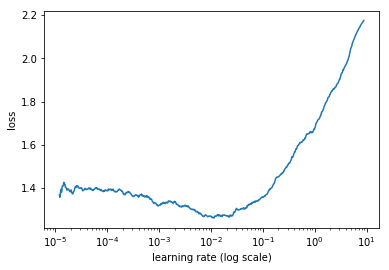

In [58]:
learn.sched.plot()

And let's get something liek a 1Cycle to train our network.

In [59]:
def one_cycle(lr, div, lengths, max_mom, min_mom, wds):
    return [TrainingPhase(lengths[0], optim.SGD, lr = (lr/div, lr), lr_decay=DecayType.LINEAR, 
                          momentum = (max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[1], optim.SGD, lr = (lr, lr/div), lr_decay=DecayType.LINEAR, 
                          momentum = (min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[2], optim.SGD, lr = lr/div, lr_decay=DecayType.COSINE, 
                          momentum = max_mom, wds=wds)]

To use our callback in the training, we just have to add it in the arguments of `fit`,`fit_opt_sched`:

In [60]:
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[SaveValidationLoss()])

--Return--                                                  
> <ipython-input-56-9aafc4cf57fe>(6)on_epoch_end()->None
-> pdb.set_trace()
(Pdb) metrics
[array([1.22454]), 0.5691]
(Pdb) q


BdbQuit: 

As seen in the debugger, `metrics` contains 2 elements, the first is our validation loss, the second is the accuracy. We can then save it and have a function plot we'll be able to call later to have the graph.

In [61]:
class SaveValidationLoss(Callback):
    def on_train_begin(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        self.val_losses.append(metrics[0])  ## okay honestly this is so cool
    
    def plot(self):
        plt.plot(list(range(len(self.val_losses))), self.val_losses)

In [62]:
save_val = SaveValidationLoss()

In [64]:
learn.load('init')
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[save_val])

  0%|          | 2/782 [00:00<03:31,  3.69it/s, loss=1.31]
epoch      trn_loss   val_loss   accuracy                   
    0      1.256746   1.195947   0.5728    
    1      1.207733   1.220033   0.5683                     
 55%|█████▍    | 429/782 [00:57<00:47,  7.45it/s, loss=1.19]

KeyboardInterrupt: 